<div style="page-break-after: always;"></div>

![](https://github.com/zumaiaUOC/DL_PRA/blob/main/media/001.png?raw=1)![](https://github.com/zumaiaUOC/DL_PRA/blob/main/media/002.jpeg?raw=1)

**M2.875 Deep Learning**

Práctica                    Autor: Oscar Rojo Martín

# *Clasificador Neuronal para la detección de Glaucoma*

<div style="page-break-after: always;"></div>

1.  Presentación

El objetivo de esta práctica es aplicar los conocimientos adquiridos durante toda la asignatura en un caso clínico real. Para ello se dispondrá de una base de datos que contiene imágenes de ojos sanos y de otros afectados por glaucoma. El glaucoma es una patología que afecta al nervio óptico y cuyos orígenes son diversos, es la segunda causa de ceguera por detrás de la diabetes y los efectos en la pérdida de visión son irreversibles. Las causas que lo producen se pueden tratar si la patología es detectada a tiempo.

El objetivo final de esta práctica es, mediante los conocimientos adquiridos, proponer y entrenar un algoritmo que sea capaz de detectar adecuadamente ojos con glaucoma frente a otros sanos.


  
1. Definición del problema

Los algoritmos de reconocimiento de imágenes se están implementando en la práctica clínica, integrándose en ocasiones directamente en el hardware que se utiliza para la exploración (por ejemplo, en los ecógrafos). Este tipo de aproximación es lo que se propone en el siguiente artículo científico, el cual se utilizará como base para realizar esta práctica:

- Diaz-Pinto, A., Morales, S., Naranjo, V. et al. *CNNs for automatic glaucoma assessment using fundus images: an extensive validation*. BioMed Eng OnLine 18, 29 (2019). <https://doi.org/10.1186/s12938-019-0649-y>

En esta práctica se dispone de una serie de imágenes de casos reales. El objetivo es obtener un modelo eficaz para detectar de manera temprana esta patología, reduciendo, por lo tanto, el riesgo de ceguera.

La base de datos está formada por imágenes en color de 224x224 píxeles y se ha dividido en 10 particiones distintas que se usarán para aplicar un método de *cross validation* con el objetivo de minimizar errores estadísticos. Cada una de estas particiones, a su vez, contiene tres subconjuntos: *train*, *test* y *valid*. Las imágenes a su vez están etiquetadas de dos formas: *normal* o *abnormal*.


2. Función de evaluación

La función de evaluación que se utilizará a lo largo de la práctica será el **F1-score**.

6. Recursos

El conjunto de los datos del proyecto se puede encontrar en la dirección:

- <https://www.kaggle.com/datasets/jordidelatorreuoc/practica-dl-uoc-2022>



In [1]:
# Clono el repositorio de GitHub donde tengo guardado todos los archivos
# Esto último lo hago para ejecutar en google colab y no tener que hacerlo en
# un notebook... que no permite grandes cantidades procesos.
#! git clone https://github.com/zumaiaUOC/DL_PRA.git
#% cd /content/DL_PRA

#### Importar librerias

In [2]:
#!pip install tf-nightly
#!pip install tensorflow-addons

In [3]:
# Import libraries
import pandas as pd # DataFrames
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from numpy import asarray
import tensorflow as tf
import sklearn
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad, Adadelta, Adamax, Nadam
from sklearn.preprocessing import OneHotEncoder
# para F1-score
import tensorflow_addons as tfa # https://www.tensorflow.org/addons/ 




In [4]:
# mount the drive
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# go to the folder with the images
#% cd /content/drive/MyDrive/Colab Notebooks/DL-PRA

#### Cargar los datos desde kaggle usando API

In [6]:
# Import data from kaggle using Kaggle API
# ref.:https://medium.com/@jeff.daniel77/accessing-the-kaggle-com-api-with-jupyter-notebook-on-windows-d6f330bc6953
# ! kaggle datasets download -d jordidelatorreuoc/practica-dl-uoc-2022


In [7]:
# unzip to data folder
# ! unzip -o practica-dl-uoc-2022.zip -d data/

In [8]:
# drop practica-dl-uoc-2022.zip
# ! rm practica-dl-uoc-2022.zip

In [9]:
# Load data
base_dir = 'data/practica_DL_UOC_2022/'

# list folder in data/practica-dl-uoc-2022/
subfolder = os.listdir(base_dir)
print(subfolder)


['Fold8', 'Fold2', 'Fold4', 'Fold3', 'Fold5', 'Fold1', 'Fold0', 'Fold9', 'Fold6', 'Fold7']


In [10]:
train_dir = os.path.join(base_dir, subfolder[0]+'/train/')
test_dir = os.path.join(base_dir, subfolder[0]+'/test/')
valid_dir = os.path.join(base_dir, subfolder[0]+'/valid/')

# directorio con imagenes normal de entrenamiento
train_normal_dir = os.path.join(train_dir, 'normal/')
# directorio con imagenes abnormal de entrenamiento
train_anormal_dir = os.path.join(train_dir, 'abnormal/')

# directorio con imagenes normal de test
test_normal_dir = os.path.join(test_dir, 'normal/')
# directorio con imagenes abnormal de test
test_anormal_dir = os.path.join(test_dir, 'abnormal/')

# directorio con imagenes normal de validacion
valid_normal_dir = os.path.join(valid_dir, 'normal/')
# directorio con imagenes abnormal de validacion
valid_anormal_dir = os.path.join(valid_dir, 'abnormal/')


In [11]:
train_anormal_dir_list = os.listdir(train_anormal_dir)
print(train_anormal_dir_list[0])

AUTPnKJWMk.jpg


#### Crear dataframe

In [12]:
df_all = pd.DataFrame()
norm_abnorm = ['normal', 'abnormal']
train_test_valid = ['train', 'test', 'valid']
for i in subfolder:
    for h in train_test_valid:
        for j in norm_abnorm:
            x_dir = os.path.join(base_dir, i+'/'+h+'/'+j+'/')
            x_dir_list = os.listdir(x_dir)
            # create a dataframe with fold, set, status, image and full_path
            df = pd.DataFrame(x_dir_list, columns=['image'])
            df['fold'] = i
            df['set'] = h
            df['status'] = j
            df['full_path'] = df['image'].apply(lambda x: os.path.join(x_dir, x))
            df_all = pd.concat([df_all, df])

df_all 

,image,fold,set,status,full_path
0,cUMznzMsuV.jpg,Fold8,train,normal,data/practica_DL_UOC_2022/Fold8/train/normal/c...
1,cheWWouKoz.jpg,Fold8,train,normal,data/practica_DL_UOC_2022/Fold8/train/normal/c...
2,nwOhbmhYxy.jpg,Fold8,train,normal,data/practica_DL_UOC_2022/Fold8/train/normal/n...
3,opYlvxALph.jpg,Fold8,train,normal,data/practica_DL_UOC_2022/Fold8/train/normal/o...
4,GCXYbvgFbl.jpg,Fold8,train,normal,data/practica_DL_UOC_2022/Fold8/train/normal/G...
...,...,...,...,...,...
67,iOPTDMYIet.jpg,Fold7,valid,abnormal,data/practica_DL_UOC_2022/Fold7/valid/abnormal...
68,cyMTZGIchB.jpg,Fold7,valid,abnormal,data/practica_DL_UOC_2022/Fold7/valid/abnormal...
69,VGUBrCcDtF.jpg,Fold7,valid,abnormal,data/practica_DL_UOC_2022/Fold7/valid/abnormal...
70,wGfehEkmNZ.jpg,Fold7,valid,abnormal,data/practica_DL_UOC_2022/Fold7/valid/abnormal...


In [13]:
# Comprobar que el numero de imagenes es correcto

In [14]:
df_all_train = pd.DataFrame()
norm_abnorm = ['normal', 'abnormal']
for i in subfolder:
    for j in norm_abnorm:
        train_dir = os.path.join(base_dir, i+'/train/')
        train_dir_dir = os.path.join(train_dir, j+'/')
        train_dir_list = os.listdir(train_dir_dir)
        # create a dataframe with fold, set, status, image, and full path
        df_train = pd.DataFrame({'fold': [i]*len(train_dir_list),
                                    'set': [j]*len(train_dir_list),
                                    'status': [j]*len(train_dir_list),
                                    'image': train_dir_list,
                                    'full_path': [os.path.join(train_dir_dir, x) for x in train_dir_list]})
        df_all_train = pd.concat([df_all_train, df_train])

df_all_train.shape
    

(13790, 5)

In [15]:
df_all_test = pd.DataFrame()
norm_abnorm = ['normal', 'abnormal']
for i in subfolder:
    for j in norm_abnorm:
        test_dir = os.path.join(base_dir, i+'/test/')
        test_dir_dir = os.path.join(test_dir, j+'/')
        test_dir_list = os.listdir(test_dir_dir)
        # create a dataframe with fold, set, status, image, and full path
        df_test = pd.DataFrame({'fold': [i]*len(test_dir_list),
                                'set': [j]*len(test_dir_list),
                                'status': [j]*len(test_dir_list),
                                'image': test_dir_list,
                                'full_path': [os.path.join(test_dir_dir, x) for x in test_dir_list]})
        df_all_test = pd.concat([df_all_test, df_test])

df_all_test.shape


(1740, 5)

In [16]:
df_all_valid = pd.DataFrame()
norm_abnorm = ['normal', 'abnormal']
for i in subfolder:
    for j in norm_abnorm:
        valid_dir = os.path.join(base_dir, i+'/valid/')
        valid_dir_dir = os.path.join(valid_dir, j+'/')
        valid_dir_list = os.listdir(valid_dir_dir)
        # create a dataframe with fold, set, status, image, and full path
        df_valid = pd.DataFrame({'fold': [i]*len(valid_dir_list),
                                 'set': [j]*len(valid_dir_list),
                                 'status': [j]*len(valid_dir_list),
                                 'image': valid_dir_list,
                                 'full_path': [os.path.join(valid_dir_dir, x) for x in valid_dir_list]})
        df_all_valid = pd.concat([df_all_valid, df_valid])

df_all_valid.shape


(1540, 5)



# **Sección 1. Análisis Exploratorio de los datos (1,5 puntos)**

Realizar un análisis exploratorio de los datos proporcionados, tanto en formato numérico como gráfico, donde se recoja la información relevante del conjunto de datos proporcionado.


Dimensión: (17070, 5)


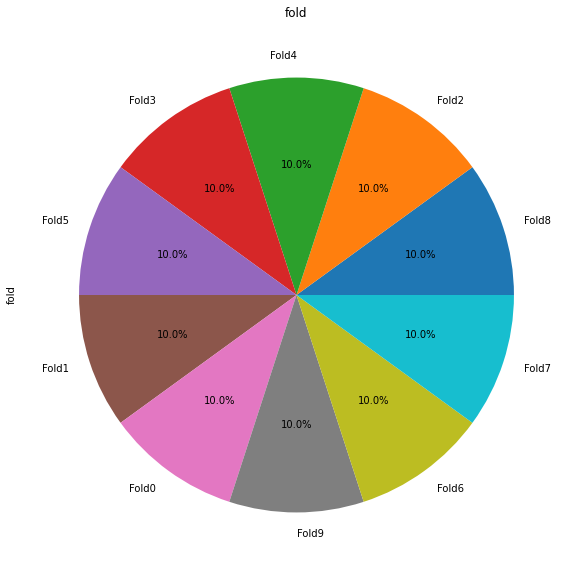

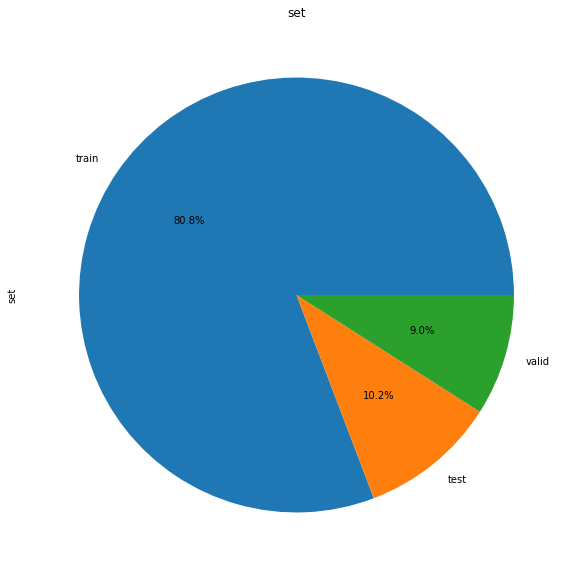

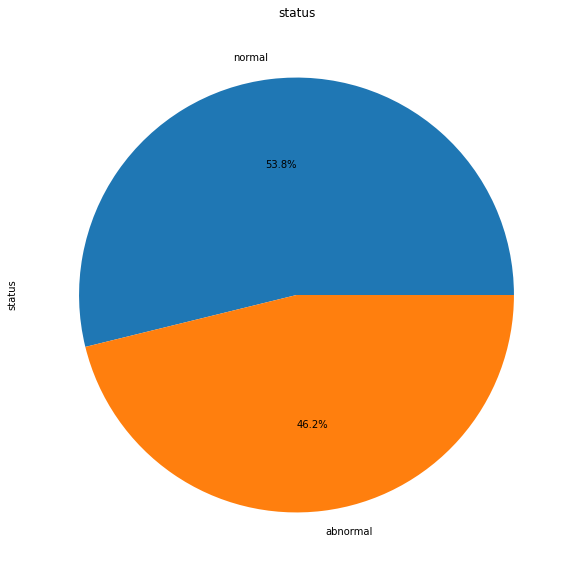

In [17]:
# Dimensión
print("Dimensión: {}".format(df_all.shape))

# list of columns
column_list = ['fold', 'set', 'status']   



# pie chart 
for i in column_list:
    df_all[i].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(10, 10))
    plt.title(i)
    plt.show()




In [19]:
# load images
def load_image(path):
    image = Image.open(path)
    image = image.resize((224, 224))
    image = np.array(image)
    return image

load_image(df_all.iloc[0]['full_path'])


array([[[141,  41,  17],
        [142,  42,  18],
        [144,  44,  20],
        ...,
        [172,  46,  23],
        [174,  48,  25],
        [174,  48,  25]],

       [[141,  41,  17],
        [142,  42,  18],
        [144,  44,  20],
        ...,
        [173,  47,  24],
        [174,  48,  25],
        [174,  48,  25]],

       [[141,  41,  17],
        [142,  42,  18],
        [144,  44,  20],
        ...,
        [174,  48,  25],
        [174,  48,  25],
        [174,  48,  25]],

       ...,

       [[147,  56,  25],
        [147,  56,  25],
        [148,  57,  26],
        ...,
        [166,  40,  15],
        [166,  40,  17],
        [165,  39,  14]],

       [[146,  55,  24],
        [147,  56,  25],
        [148,  57,  26],
        ...,
        [166,  42,  14],
        [165,  41,  15],
        [164,  40,  12]],

       [[146,  55,  24],
        [147,  56,  25],
        [148,  57,  26],
        ...,
        [166,  42,  14],
        [165,  41,  13],
        [164,  40,  12]]

In [ ]:
df_all_normal = df_all[df_all['status'] == 'normal']
df_all_abnormal = df_all[df_all['status'] == 'abnormal']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Imagen Normal
JPEG
RGB
(224, 224)
Mean: 95.720
Min: 10.000, Max: 251.000
Mean: -0.000
Min: -85.720, Max: 155.280
Data Type: float64
Min: -85.720, Max: 155.280
pixel mean =  3.5478955e-09
Min: -0.336, Max: 0.609


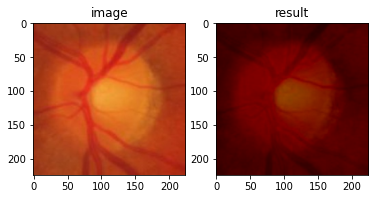

Imagen Abnormal
JPEG
RGB
(224, 224)
Mean: 69.391
Min: 0.000, Max: 187.000
Mean: -0.000
Min: -69.391, Max: 117.609
Data Type: float64
Min: -69.391, Max: 117.609
pixel mean =  3.7506322e-09
Min: -0.272, Max: 0.461


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


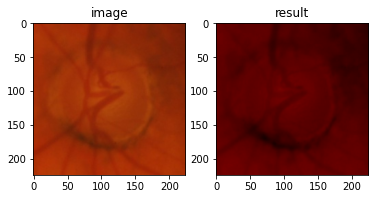

In [38]:
def image_info(path):
    image = Image.open(path)
    print(image.format)
    print(image.mode)
    print(image.size)
    pixels = asarray(image)
    # global centering


    # calculate global mean
    mean = pixels.mean()
    print('Mean: %.3f' % mean)
    print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))
    # global centering of pixels
    pixels = pixels - mean
    # confirm it had the desired effect
    mean = pixels.mean()
    print('Mean: %.3f' % mean)
    print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))
    #print(pixels)


    # example of pixel normalization
    # confirm pixel range is 0-255
    print('Data Type: %s' % pixels.dtype)
    print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))
    # convert from integers to floats
    pixels = pixels.astype('float32')
    # normalize to the range 0-1
    pixels /= 255.0
    mean = pixels.mean()
    print('pixel mean = ', mean)

    # confirm the normalization
    print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))

    # show the image
    fig, (ax0, ax1) = plt.subplots(1, 2)
    ax0.imshow(image)
    ax0.axis('on')
    ax0.set_title('image')
    ax1.imshow(pixels)
    ax1.axis('on')
    ax1.set_title('result')
    plt.show()
    
print('Imagen Normal')
image_info(df_all_normal.iloc[0]['full_path'])
print('Imagen Abnormal')
image_info(df_all_abnormal.iloc[0]['full_path'])


In [45]:
def imagen(path):
    image = Image.open(path)
    pixels = asarray(image) # convert image to numpy array
    # calculate global mean
    mean = pixels.mean()
    # global centering of pixels
    pixels = pixels - mean
    # convert from integers to floats
    pixels = pixels.astype('float32')
    # normalize to the range 0-1
    pixels /= 255.0
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 14))
    ax0.imshow(image)
    ax0.axis('on')
    ax0.set_title('original image', fontsize=20)
    ax1.imshow(pixels)
    ax1.axis('on')
    ax1.set_title('result', fontsize=20)
    plt.show()

# imagen(df_all.iloc[0]['full_path'])

##### ojo sano:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


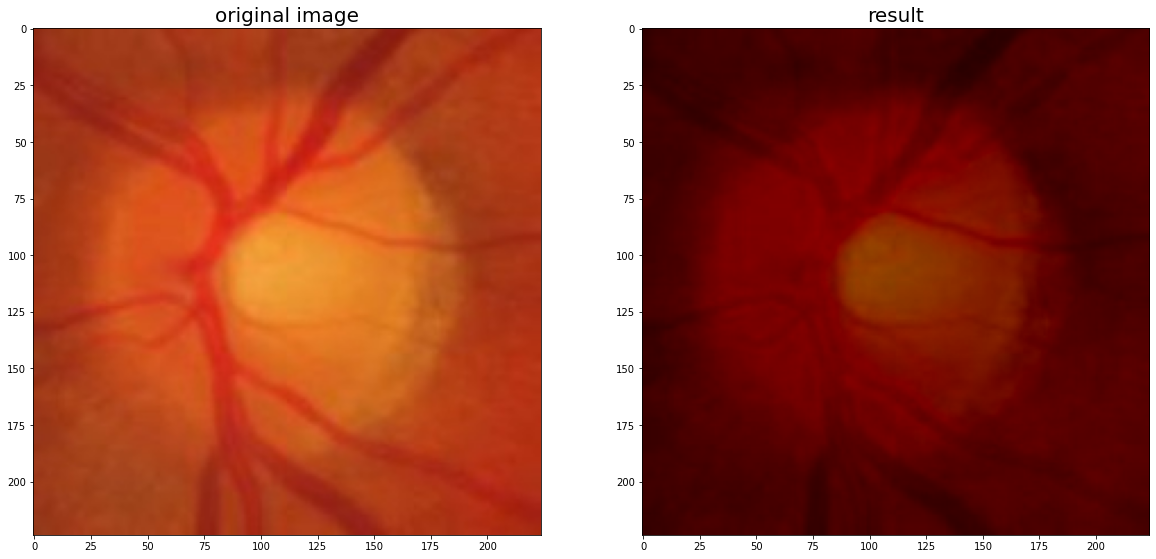

In [46]:
# filter df_all status = normal
imagen(df_all_normal.iloc[0]['full_path'])

##### ojo con Glaucoma:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


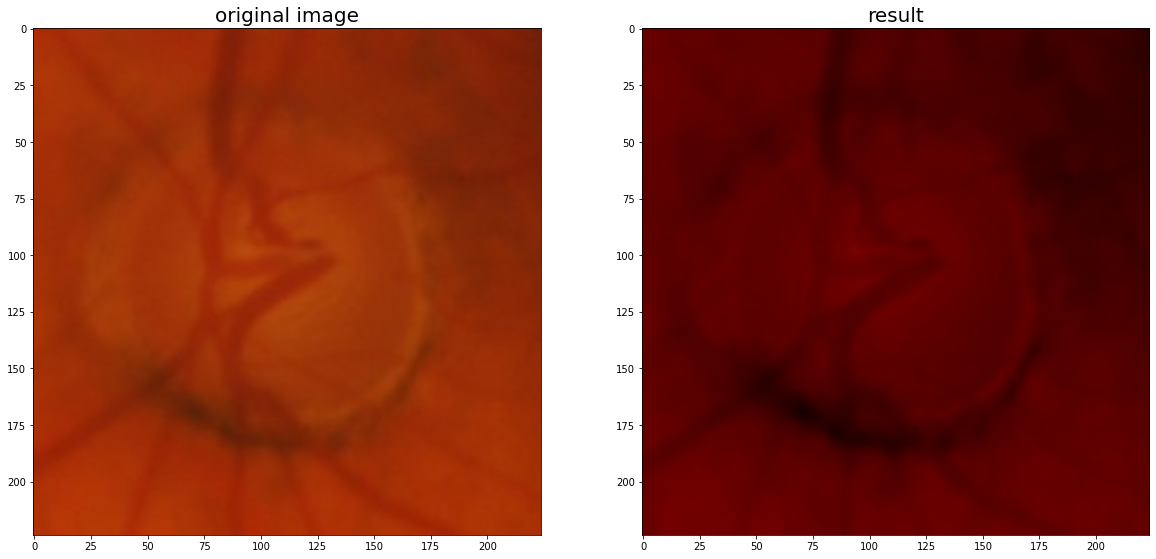

In [47]:
# filter df_all status = abnormal
imagen(df_all_abnormal.iloc[0]['full_path'])


# **Sección 2. Entrenamiento de una red neuronal sobre una única partición (4 puntos)**

En esta primera parte se hará un entrenamiento únicamente sobre el **fold0**. Esto nos permitirá obtener conclusiones preliminares en un plazo razonable de tiempo, antes de ejecutar un entrenamiento completo empleando *cross validation* (ver sección 3). Para ello se deben proponer y comparar 5 aproximaciones distintas:

- Las 3 primeras configuraciones se deben implementar en un modelo basado en *EfficientNet B0*, preentrenado con los pesos de Imagenet, al que se le sustituye su capa de clasificación por: una capa de *GlobalAveragePolling2D*, una capa de *BatchNormalization*, una capa de *dropout* con probabilidad del 20%, y finalmente una capa *fully connected*.
  - En la primera configuración se entrena el modelo congelando todas las capas menos las que se han añadido al final (**modelo 1**).
  - En una segunda configuración, a partir de los pesos encontrados para el modelo 1, se entrena descongelando las últimas 20 capas, pero dejando las capas de *BatchNorm* congeladas (**modelo 2**).
  - En la tercera configuración, a partir de los pesos del modelo 2, se descongelan todas las capas y se entrena la red en su totalidad (**modelo 3**).
- Entrenar dos configuraciones, modelos o arquitecturas adicionales, que se pueden escoger libremente (**modelo 4** y **modelo 5**).

En todos los casos, se debe indicar y justificar:

- Elegir la época e hiperparámetros que mejor resultados hayan proporcionado sobre el conjunto de validación durante el entrenamiento.
- Proporcionar y discutir los resultados sobre el conjunto de test.
- Obtener la matriz de confusión, y discutir los resultados teniendo en cuenta los objetivos del problema.


In [48]:
df_all

,image,fold,set,status,full_path
0,cUMznzMsuV.jpg,Fold8,train,normal,data/practica_DL_UOC_2022/Fold8/train/normal/c...
1,cheWWouKoz.jpg,Fold8,train,normal,data/practica_DL_UOC_2022/Fold8/train/normal/c...
2,nwOhbmhYxy.jpg,Fold8,train,normal,data/practica_DL_UOC_2022/Fold8/train/normal/n...
3,opYlvxALph.jpg,Fold8,train,normal,data/practica_DL_UOC_2022/Fold8/train/normal/o...
4,GCXYbvgFbl.jpg,Fold8,train,normal,data/practica_DL_UOC_2022/Fold8/train/normal/G...
...,...,...,...,...,...
67,iOPTDMYIet.jpg,Fold7,valid,abnormal,data/practica_DL_UOC_2022/Fold7/valid/abnormal...
68,cyMTZGIchB.jpg,Fold7,valid,abnormal,data/practica_DL_UOC_2022/Fold7/valid/abnormal...
69,VGUBrCcDtF.jpg,Fold7,valid,abnormal,data/practica_DL_UOC_2022/Fold7/valid/abnormal...
70,wGfehEkmNZ.jpg,Fold7,valid,abnormal,data/practica_DL_UOC_2022/Fold7/valid/abnormal...


In [49]:
# save df_all as csv
df_all.to_csv('data/df_all.csv', index=False)

In [50]:
# Filter data_all by fold
df_fold_0 = df_all[df_all['fold'] == 'Fold0']
df_fold_0.head()

df_fold_0_train = df_fold_0[df_fold_0['set'] == 'train']
df_fold_0_test = df_fold_0[df_fold_0['set'] == 'test']
df_fold_0_valid = df_fold_0[df_fold_0['set'] == 'valid']
y_train = pd.get_dummies(df_fold_0_train['status'])
y_valid = pd.get_dummies(df_fold_0_valid['status'])
y_test = pd.get_dummies(df_fold_0_test['status'])

In [27]:
# convert df_fold_0_train['status'] to one-hot encoding
#df_fold_0_train['status'] = df_fold_0_train['status'].map({'normal': 0, 'abnormal': 1})
#df_fold_0_valid['status'] = df_fold_0_valid['status'].map({'normal': 0, 'abnormal': 1})
#df_fold_0_test['status'] = df_fold_0_test['status'].map({'normal': 0, 'abnormal': 1})


In [51]:
# convert df_fold_0_train to a numpy array
X_train = np.array([load_image(x) for x in df_fold_0_train['full_path']])
#y_train = np.array(df_fold_0_train['status'])
y_train = np.array(y_train)

# get max and min values of X_train
X_train_min = X_train.min()
X_train_max = X_train.max()
# normalize X_train
X_train = (X_train - X_train_min) / (X_train_max - X_train_min)


print("X_train :",X_train.shape)
print("y_train :",y_train.shape)

X_train : (1379, 224, 224, 3)
y_train : (1379, 2)


In [52]:
# convert df_fold_0_train to a numpy array
x_valid = np.array([load_image(x) for x in df_fold_0_valid['full_path']])
#y_valid = np.array(df_fold_0_valid['status'])
y_valid = np.array(y_valid)
x_valid_min = x_valid.min()
print("min_valid:", x_valid_min)
x_valid_max = x_valid.max()
print("max_valid:", x_valid_max)
# normalize X_train
x_valid = (x_valid - x_valid_min) / (x_valid_max - x_valid_min)

min_valid: 0
max_valid: 255


In [53]:
# convert df_fold_0_train to a numpy array
x_test = np.array([load_image(x) for x in df_fold_0_test['full_path']])
#y_test = np.array(df_fold_0_test['status'])
y_text = np.array(y_test)
x_test_min = x_test.min()
print("min_valid:", x_test_min)
x_test_max = x_test.max()
print("max_test:", x_test_max)
# normalize X_train
x_test = (x_test - x_test_min) / (x_test_max - x_test_min)

min_valid: 0
max_test: 255


### Modelo 1
Modelo basado en *EfficientNet B0*, preentrenado con los pesos de Imagenet, al que se le sustituye su capa de clasificación por: una capa de *GlobalAveragePolling2D*, una capa de *BatchNormalization*, una capa de *dropout* con probabilidad del 20%, y finalmente una capa *fully connected*.
Se entrena el modelo congelando todas las capas menos las que se han añadido al final 

In [54]:
def model_builder(n_classes, shape, optimizador, lr):
    inputs = layers.Input(shape=shape, name='input')
    # base model EfficientNetB0 with pre-trained weights imagenet
    base_model = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False)
    # freeze all layers of base model
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model(inputs)

    # Add Global Average Pooling 2D
    x = layers.GlobalAveragePooling2D(name='GlobalAveragePooling2D')(x)
    # Add BatchNormalization
    x = layers.BatchNormalization(name='BatchNormalization')(x)
    # add Dropout with 0.2 probability
    x = layers.Dropout(0.2, name='Dropout')(x)
    # unfreeze last layer of base model
    base_model.layers[-1].trainable = True
    # fully connected layer with softmax activation
    output = layers.Dense(n_classes, activation='softmax', name='output')(x)
    # create model
    model = tf.keras.Model(inputs=inputs, outputs=output)
    # compile model
    #model.compile(optimizer=optimizador, loss='categorical_crossentropy', metrics=['accuracy'])
    model.compile(optimizer=optimizador, loss='categorical_crossentropy',
                  metrics=tfa.metrics.F1Score(num_classes=n_classes, average='macro'))
    # summarize model
    model.summary()
    return model

model_builder(2, (224, 224, 3), 'Adam', 0.0001)



2022-06-01 09:04:46.035753: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-01 09:04:46.095452: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-01 09:04:46.095673: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-01 09:04:46.096570: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 GlobalAveragePooling2D (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 BatchNormalization (BatchNo  (None, 1280)             5120      
 rmalization)                                                    
                                                                 
 Dropout (Dropout)           (None, 1280)              0         
                                                                 
 output (Dense)              (None, 2)                 2562  

In [57]:

def model_1_build(n_classes, shape, optimizer, lr):
    #print('Number of classes:', n_classes, '\nShape:', shape, '\nOptimizer:', optimizer, '\nLearning rate:', lr)
    inputs = layers.Input(shape=shape, name='inputs')
    # base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    base_model = tf.keras.applications.EfficientNetB0(
        include_top=False, weights='imagenet')

    # Freeze layers
    base_model.trainable = False
    x = base_model(inputs, training=False)

    # Add new layers
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(n_classes, activation='sigmoid', name='outputs')(x)

    if optimizer == 'Adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    elif optimizer == 'SGD':
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

    # set metrics f1_score
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy',
    metrics=tfa.metrics.F1Score(num_classes=n_classes, average='macro'))
    

    model.summary()

    return model


In [58]:
model=model_1_build(2, (224, 224, 3), 'Adam', 0.0001)
model_1=model_1_build(2, (224, 224, 3), 'Adam', 0.0001)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_1 (Batc  (None, 1280)             5120      
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 outputs (Dense)             (None, 2)                 2562

In [61]:

# choose the epoch and hyperparameters for the model over validation set during training
params = {
    'epochs': [1, 2, 5, 10, 50, 80, 100],
    'optimizer': ['Adam', 'SGD'],
    'lr': [0.0001, 0.001, 0.01, 0.1]
}


In [62]:
# fit the model
def fit_model(model, X_train, y_train, x_valid, y_valid, params):
    # create a dataframe to store the results
    results = pd.DataFrame(columns=['epochs', 'optimizer', 'lr', 'loss', 'accuracy'])

    # loop over epochs, optimizers and learning rates
    for epochs in params['epochs']:
        for optimizer in params['optimizer']:
            for lr in params['lr']:
                print('Epochs:', epochs, '\tOptimizer:', optimizer, '\tLearning rate:', lr)
                # create a new model
                model = model_1_build(n_classes=2, shape=X_train.shape[1:], optimizer=optimizer, lr=lr)

                # train the model
                history = model.fit(X_train, y_train, validation_data=(x_valid, y_valid), epochs=epochs, verbose=0)

                # evaluate the model
                loss, accuracy = model.evaluate(x_valid, y_valid, verbose=0)

                # store the results
                results = results.append({'epochs': epochs, 'optimizer': optimizer, 'lr': lr, 'loss': loss, 'accuracy': accuracy}, ignore_index=True)
                

    # save the results
    results.to_csv('data/results.csv', index=False)

    imprimir = results

    return imprimir

fit_model(model, X_train, y_train, x_valid, y_valid, params)

Epochs: 1 	Optimizer: Adam 	Learning rate: 0.0001
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_4   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_4 (Batc  (None, 1280)             5120      
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 1280)              0         
                                                                 
 outputs 

2022-06-01 09:08:07.240693: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 830312448 exceeds 10% of free system memory.
2022-06-01 09:08:07.836064: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 830312448 exceeds 10% of free system memory.
2022-06-01 09:08:12.242948: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 19267584 exceeds 10% of free system memory.
2022-06-01 09:08:12.243112: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 19267584 exceeds 10% of free system memory.
2022-06-01 09:08:12.243258: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 19267584 exceeds 10% of free system memory.
2022-06-01 09:08:13.942837: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-06-01 09:08:15.626624: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-06-01 09:08:16.768779: I tensorflow/stream_exe

Epochs: 1 	Optimizer: Adam 	Learning rate: 0.001
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_5   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_5 (Batc  (None, 1280)             5120      
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 1280)              0         
                                                                 
 outputs (

2022-06-01 09:08:42.512559: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 147.00MiB (rounded to 154140672)requested by op model_5/efficientnetb0/block2a_expand_bn/FusedBatchNormV3
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-06-01 09:08:42.512706: I tensorflow/core/common_runtime/bfc_allocator.cc:1027] BFCAllocator dump for GPU_0_bfc
2022-06-01 09:08:42.512730: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (256): 	Total Chunks: 467, Chunks in use: 465. 116.8KiB allocated for chunks. 116.2KiB in use in bin. 35.5KiB client-requested in use in bin.
2022-06-01 09:08:42.512748: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (512): 	Total Chunks: 456, Chunks in use: 456. 287.0KiB allocated for chunks. 287.0KiB in use in bin. 233.9KiB c

ResourceExhaustedError: Graph execution error:

Detected at node 'model_5/efficientnetb0/block2a_expand_bn/FusedBatchNormV3' defined at (most recent call last):
    File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/home/oscar/Documentos/oscar/DL/PRA/my_venv_PRA/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/oscar/Documentos/oscar/DL/PRA/my_venv_PRA/lib/python3.10/site-packages/traitlets/config/application.py", line 972, in launch_instance
      app.start()
    File "/home/oscar/Documentos/oscar/DL/PRA/my_venv_PRA/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/home/oscar/Documentos/oscar/DL/PRA/my_venv_PRA/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 600, in run_forever
      self._run_once()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 1896, in _run_once
      handle._run()
    File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/oscar/Documentos/oscar/DL/PRA/my_venv_PRA/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 504, in dispatch_queue
      await self.process_one()
    File "/home/oscar/Documentos/oscar/DL/PRA/my_venv_PRA/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 493, in process_one
      await dispatch(*args)
    File "/home/oscar/Documentos/oscar/DL/PRA/my_venv_PRA/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 400, in dispatch_shell
      await result
    File "/home/oscar/Documentos/oscar/DL/PRA/my_venv_PRA/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 724, in execute_request
      reply_content = await reply_content
    File "/home/oscar/Documentos/oscar/DL/PRA/my_venv_PRA/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/home/oscar/Documentos/oscar/DL/PRA/my_venv_PRA/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/oscar/Documentos/oscar/DL/PRA/my_venv_PRA/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/home/oscar/Documentos/oscar/DL/PRA/my_venv_PRA/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/home/oscar/Documentos/oscar/DL/PRA/my_venv_PRA/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/oscar/Documentos/oscar/DL/PRA/my_venv_PRA/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/oscar/Documentos/oscar/DL/PRA/my_venv_PRA/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/oscar/Documentos/oscar/DL/PRA/my_venv_PRA/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_6667/3914642302.py", line 31, in <cell line: 31>
      fit_model(model, X_train, y_train, x_valid, y_valid, params)
    File "/tmp/ipykernel_6667/3914642302.py", line 15, in fit_model
      history = model.fit(X_train, y_train, validation_data=(x_valid, y_valid), epochs=epochs, verbose=0)
    File "/home/oscar/Documentos/oscar/DL/PRA/my_venv_PRA/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/oscar/Documentos/oscar/DL/PRA/my_venv_PRA/lib/python3.10/site-packages/keras/engine/training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/oscar/Documentos/oscar/DL/PRA/my_venv_PRA/lib/python3.10/site-packages/keras/engine/training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "/home/oscar/Documentos/oscar/DL/PRA/my_venv_PRA/lib/python3.10/site-packages/keras/engine/training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/oscar/Documentos/oscar/DL/PRA/my_venv_PRA/lib/python3.10/site-packages/keras/engine/training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "/home/oscar/Documentos/oscar/DL/PRA/my_venv_PRA/lib/python3.10/site-packages/keras/engine/training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "/home/oscar/Documentos/oscar/DL/PRA/my_venv_PRA/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/oscar/Documentos/oscar/DL/PRA/my_venv_PRA/lib/python3.10/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/oscar/Documentos/oscar/DL/PRA/my_venv_PRA/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/oscar/Documentos/oscar/DL/PRA/my_venv_PRA/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/oscar/Documentos/oscar/DL/PRA/my_venv_PRA/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/oscar/Documentos/oscar/DL/PRA/my_venv_PRA/lib/python3.10/site-packages/keras/engine/functional.py", line 458, in call
      return self._run_internal_graph(
    File "/home/oscar/Documentos/oscar/DL/PRA/my_venv_PRA/lib/python3.10/site-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/oscar/Documentos/oscar/DL/PRA/my_venv_PRA/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/oscar/Documentos/oscar/DL/PRA/my_venv_PRA/lib/python3.10/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/oscar/Documentos/oscar/DL/PRA/my_venv_PRA/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/oscar/Documentos/oscar/DL/PRA/my_venv_PRA/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/oscar/Documentos/oscar/DL/PRA/my_venv_PRA/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/oscar/Documentos/oscar/DL/PRA/my_venv_PRA/lib/python3.10/site-packages/keras/engine/functional.py", line 458, in call
      return self._run_internal_graph(
    File "/home/oscar/Documentos/oscar/DL/PRA/my_venv_PRA/lib/python3.10/site-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/oscar/Documentos/oscar/DL/PRA/my_venv_PRA/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/oscar/Documentos/oscar/DL/PRA/my_venv_PRA/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/oscar/Documentos/oscar/DL/PRA/my_venv_PRA/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/oscar/Documentos/oscar/DL/PRA/my_venv_PRA/lib/python3.10/site-packages/keras/layers/normalization/batch_normalization.py", line 750, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "/home/oscar/Documentos/oscar/DL/PRA/my_venv_PRA/lib/python3.10/site-packages/keras/layers/normalization/batch_normalization.py", line 594, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "/home/oscar/Documentos/oscar/DL/PRA/my_venv_PRA/lib/python3.10/site-packages/keras/utils/control_flow_util.py", line 105, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "/home/oscar/Documentos/oscar/DL/PRA/my_venv_PRA/lib/python3.10/site-packages/keras/layers/normalization/batch_normalization.py", line 584, in _fused_batch_norm_inference
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'model_5/efficientnetb0/block2a_expand_bn/FusedBatchNormV3'
OOM when allocating tensor with shape[32,96,112,112] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_5/efficientnetb0/block2a_expand_bn/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_62773]

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer

In [ ]:
predictions = model_1.predict(x_test)
y_pred = np.argmax(predictions, axis=1)
y_pred = np.append(y_pred,y_pred)
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:

y_true = y_test
y_true = LabelBinarizer().fit_transform(y_true)
y_true = y_true.flatten()
y_true

array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,

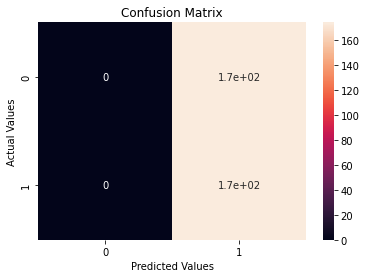

In [ ]:
conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)

df_conf_matrix = pd.DataFrame(conf_matrix)


sns.heatmap(df_conf_matrix, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()


In [ ]:
#! echo 0 | sudo tee -a /sys/bus/pci/devices/NNNNN/numa_node

In [68]:
# Model 1
# Modelo basado en *EfficientNet B0*, preentrenado con los pesos de Imagenet, al que se le sustituye su capa de clasificación por: una capa de *GlobalAveragePolling2D*, una capa de *BatchNormalization*, una capa de *dropout* con probabilidad del 20%, y finalmente una capa *fully connected*
def creador_modelo(n_classes, shape, optimizer, lr):
    prev_model = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet', input_shape=shape)
    model_1 = models.Sequential()
    # freeze layers
    for layer in model_1.layers:
        layer.trainable = False
    model_1.add(prev_model)
    # sustituir la capa de clasificación por una capa GlobalAveragePooling2D
    model_1.add(layers.GlobalAveragePooling2D(name='GlobalAveragePooling2D'))
    # layer of "BatchNormalization"
    model_1.add(layers.BatchNormalization())
    # layer of "Dropout"
    model_1.add(layers.Dropout(0.2))
    # layer of Fully Connected
    model_1.layers[-1].trainable = True
    model_1.add(layers.Dense(n_classes, activation='sigmoid'))
    # compile the model
    if optimizer == 'Adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    elif optimizer == 'SGD':
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
    #model_1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model_1.summary()


    # compile the model
    model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                            loss='binary_crossentropy',
                            metrics=tfa.metrics.F1Score(num_classes=n_classes, average='macro'),
                            run_eagerly=True)
    #model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                    # loss='binary_crossentropy',
                    # metrics=['accuracy'], run_eagerly=True)
    # freeze layers
    for layer in model_1.layers:
        layer.trainable = False
    # save the model
    model_1.save('data/models/model_1.h5')

    # save weights
    model_1.save_weights('data/models/model_1_weights.h5')

    return model_1


In [ ]:
# create parameters for the model
params = {
    'epochs': [1, 2, 5, 10, 50, 80, 100],
    'optimizer': ['Adam', 'SGD'],
    'lr': [0.0001, 0.001, 0.01, 0.1]
}

In [69]:

creador_modelo(2, (224, 224, 3), 'Adam', 0.0001)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 GlobalAveragePooling2D (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 batch_normalization_6 (Batc  (None, 1280)             5120      
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 4,057,253
Trainable params: 4,012,670
Non-

In [37]:
train = X_train
batch_size = 32
valid = x_valid
steps_per_epoch = train // batch_size
validation_steps = valid // batch_size
epoch = 10
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        verbose=1,
        mode='auto',
        min_delta=0.0001,
        cooldown=0,
        min_lr=0
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=5,
        verbose=1,
        mode='auto',
        baseline=None,
        restore_best_weights=True
    )
]


In [38]:
# train the model
history_1 = model_1.fit(x=X_train,
                        y=y_train,
                        batch_size=batch_size,
                        epochs=10,
                        validation_data=(x_valid,y_valid),
                        callbacks=callbacks,
                        verbose=1)
                        

Epoch 1/10
44/44 [==============================] - 21s 131ms/step - loss: 0.6868 - accuracy: 0.5381 - val_loss: 0.6976 - val_accuracy: 0.4610 - lr: 1.0000e-04
Epoch 2/10
44/44 [==============================] - 4s 90ms/step - loss: 0.6810 - accuracy: 0.5446 - val_loss: 0.6957 - val_accuracy: 0.4610 - lr: 1.0000e-04
Epoch 3/10
44/44 [==============================] - 4s 87ms/step - loss: 0.6778 - accuracy: 0.5431 - val_loss: 0.6966 - val_accuracy: 0.4610 - lr: 1.0000e-04
Epoch 4/10
44/44 [==============================] - 4s 84ms/step - loss: 0.6744 - accuracy: 0.5417 - val_loss: 0.6936 - val_accuracy: 0.4610 - lr: 1.0000e-04
Epoch 5/10
44/44 [==============================] - 3s 76ms/step - loss: 0.6718 - accuracy: 0.5460 - val_loss: 0.6926 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 6/10
44/44 [==============================] - 3s 77ms/step - loss: 0.6686 - accuracy: 0.5497 - val_loss: 0.6901 - val_accuracy: 0.5584 - lr: 1.0000e-04
Epoch 7/10
44/44 [==============================] 

In [39]:
# get f1 score
from sklearn.metrics import f1_score

# get f1 from the history
f1_1 = f1_score(y_true=y_test, y_pred=model_1.predict(x_test), average='macro')
f1_1

ValueError: ignored

In [40]:
model_1.evaluate(X_train, y_train, batch_size=10)

138/138 [==============================] - 4s 28ms/step - loss: 0.6800 - accuracy: 0.5547


[0.6800439953804016, 0.5547498464584351]

In [41]:
model_1.evaluate(x_valid, y_valid, batch_size=10)

16/16 [==============================] - 1s 53ms/step - loss: 0.6832 - accuracy: 0.5649


[0.6831540465354919, 0.5649350881576538]

In [42]:
model_1.evaluate(x_test, y_test)

6/6 [==============================] - 0s 61ms/step - loss: 0.6856 - accuracy: 0.5000


[0.6856000423431396, 0.5]

In [44]:
predictions = model_1.predict_generator(x_test)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

true_classes = y_test.classes
class_labels = list(y_test.class_indices.keys())  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


AttributeError: ignored

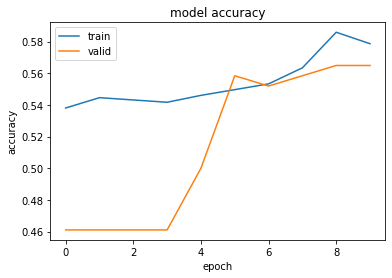

In [45]:
# plot the training history
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()



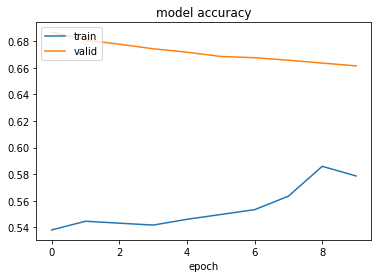

In [46]:
# plot accuracy and loss
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['loss'])
plt.title('model accuracy')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()


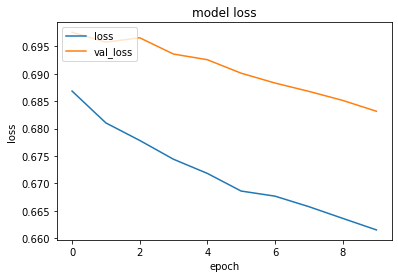

In [47]:
# plot the training history
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

In [ ]:
batch_normalization,
def model_1_biuid(n_classes, shape, optimizer, lr):
  print('Número clases: ', n_classes, '\nshape', shape, 'ªnLearning rate ', lr)
  inputs = layers.Input(shape = shape, name='inputLayer')
  base_model = EfficientNetB0(weights='imagenet', include_top = False)

  #Congelamos capas
  base_model.trainable=False
  x = base_model(inputs, training = False)

  #Añadimos capas
  x = Global AveragePooling2D()(x)
  x = batch_normalization(x)
  x = Dropout(0.2)(x)

  #Compilamos
  model = Model(inputs, outputs)
  model.compile(loss = 'categorical_crossentropy', 
                optimizer=optimizer(learning_rate=lr), 
                metrics=['acc'])
  
  return model


In [ ]:
def build_generator(data_path, img_size=(32,32), batch_size=32):
    print('[Build_generators] dir', data_path, 'img:', img_size, 'batch_size', batch_size)
  # initialize the training data augmentation object
    train_aug = tf.keras.preprocessiong.image.ImageDataGenerator(
        rescale=1.0/255,
        rotation_range = 20,
        zoom_range =0.05,
        width_shift_range = 0.05,
        height_shift_range = 0.05,
        shear_range = 0.05,
        horizonal_flip=True,
        fill_mode='nearest')
  
  # initialize the validation (and testing) data augmentation object
    val_aug = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)



    # initialize the training generator
    train_path = os.path.join(data_path, 'train')
    print('[build_generators] train', train_path)
    train_gen = train_aug.flow_from_directory(
        directory = train_path, 
        class_mode = "categorical",
        target_size =  img_size,
        #color_mode="rgb"
        shuffle=True,
        batch_size = batch_size
    )

    val_gen = val_aug.flow_from_directory(
            directory = os.path.join(data_path, 'valid'),
            class_mode = "categorical",
            target_size = img_size,
            #color_mode="rgb"
            shuffle=True,
            batch_size = batch_size
        )


    # initialize the validation generator
    val_path = os.path.join(data_path, 'valid')
    print('[build_generators] test:', test_path)
    test_gen = val_aug.flow_from_directory(
        directory= test_path,
        class_mode = 'categorical',
        target_size = img_size,
        color_mode ='rbg',
        shuffle = False,
        batch_size = batch_size
    )

    return train_gen, val_gen, test_gen

In [ ]:
build_generator('data/practica_DL_UOC_2022/')

In [ ]:
tf.random.set_seed(42)
def build_model(num_classes, shape, lr=1e-4):
  print('[build-model] num_classes:', num_classes, 'shape:', shape, 'lr', lr)
  inputs = tf.keras.layers.Input(shape=shape, name='input_layer')

  basel_model = tf.keras.aplications.efficientnet.EfficientNetB0(
      include_top=False, weights='imagenet')
  
  # Freeze the pretraineed weights
  base_model.trainable = False
  x = base_model(inputs, training = False)

  # Rebuild top
  x = tf.keras.layer.GlobalAveragePolling2D(name="avg_pool")(x)
  x = tf.keras.layer.BatchNormalization()(x)

  top_dropout_rate = 0.2
  x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
  outputs = tf.keras.layers.Dense(num_classes, activation='softmax', name='pred')(x)

  # compile
  model = tf.keras.Model(inputs, outputs, name="EfficientNet")

  optimizer = tf.keras.optimizers.Adam()
  model.compile(
      optimizer=optimizer,
      loss="categorical_crossentropy",
      metrics=['accuracy']
  )
  return model

In [ ]:
from keras.backend import shape
build_model(2, 32)

In [ ]:
from gc import callbacks
callbacks=[reduce_lr]

In [ ]:
# Fit
total_train = train_gen.samples
total_val = val_gen.samples
total_test =test_gen.samples

steps_per_epoch = total_train // batch_size
validation_steps = total_val // batch_size

print('[train] total_train:', total_train, 'total_val:', total_Val, 'total_test:', total_test, 'epochs:', epochs)
print('[train] steps_per_epoch:', steps_per_epoch)
print('[train] validation_steps:', validtion_steps)
H = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data_val=gen,
    validation_steps=validation_steps,
    epochs=epochs #,callsbacks=callbacks
)

### Modelo 2
modelo basado en *EfficientNet B0*, preentrenado con los pesos de Imagenet, al que se le sustituye su capa de clasificación por: una capa de *GlobalAveragePolling2D*, una capa de *BatchNormalization*, una capa de *dropout* con probabilidad del 20%, y finalmente una capa *fully connected*.
 A partir de los pesos encontrados para el modelo 1, se entrena descongelando las últimas 20 capas, pero dejando las capas de *BatchNorm* congeladas  

In [48]:
shape = (224, 224, 3)
num_classes = 2

In [49]:
head_model = tf.keras.applications.EfficientNetB0(input_shape=shape, include_top=False, weights='imagenet')
# Freeze all layers
head_model.trainable = False
inputs = tf.keras.layers.Input(shape=shape)
# añadimos capas
head_model = head_model(inputs, training=True)
# GlobalMaxPooling2D
head_model = tf.keras.layers.GlobalAveragePooling2D()(head_model)
head_model = tf.keras.layers.BatchNormalization()(head_model)
head_model = Dropout(0.2)(head_model)
outputs = Dense(num_classes, activation='softmax')(head_model)
model2 = tf.keras.Model(inputs, outputs)

# cargamos los pesos del modelo 1
model2.load_weights('data/models/model_1_weights.h5',
                    skip_mismatch=False, by_name=True)

# entrenamos las 20 últimas capas
for layer in model2.layers[:20]:
  layer.trainable = True

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
lr = 1e-4
epochs = 10
batch_size = 32
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        verbose=1,
        mode='auto',
        min_delta=0.0001,
        cooldown=0,
        min_lr=0
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=5,
        verbose=1,
        mode='auto',
        baseline=None,
        restore_best_weights=True
    )
]

# Compile
model2.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_3 (Batc  (None, 1280)             5120      
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 2)                 2562

In [57]:
# freeze layers
for layer in model2.layers:
  layer.trainable = False

# save model2
model2.save('data/models/model_2.h5')
# save weights of model2
model2.save_weights('data/models/model_2_weights.h5')


In [51]:

# Fit
H_model_2 = model2.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=callbacks
)



Epoch 1/10
44/44 [==============================] - 26s 374ms/step - loss: 0.6482 - accuracy: 0.7244 - val_loss: 0.6981 - val_accuracy: 0.5977 - lr: 1.0000e-04
Epoch 2/10
44/44 [==============================] - 15s 337ms/step - loss: 0.3547 - accuracy: 0.8470 - val_loss: 0.7520 - val_accuracy: 0.5690 - lr: 1.0000e-04
Epoch 3/10
44/44 [==============================] - ETA: 0s - loss: 0.2613 - accuracy: 0.8861
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
44/44 [==============================] - 14s 326ms/step - loss: 0.2613 - accuracy: 0.8861 - val_loss: 0.7886 - val_accuracy: 0.5920 - lr: 1.0000e-04
Epoch 4/10
44/44 [==============================] - 14s 320ms/step - loss: 0.1819 - accuracy: 0.9260 - val_loss: 0.8670 - val_accuracy: 0.5747 - lr: 5.0000e-05
Epoch 5/10
44/44 [==============================] - ETA: 0s - loss: 0.1653 - accuracy: 0.9347
Epoch 5: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
44/44 [========================

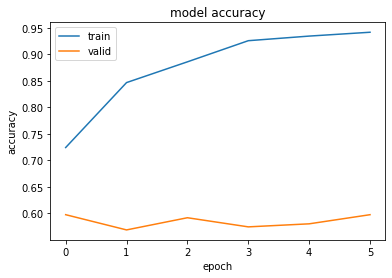

In [52]:
# plot the training history
plt.plot(H_model_2.history['accuracy'])
plt.plot(H_model_2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

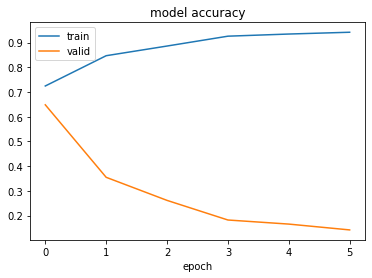

In [53]:
# plot accuracy and loss
plt.plot(H_model_2.history['accuracy'])
plt.plot(H_model_2.history['loss'])
plt.title('model accuracy')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

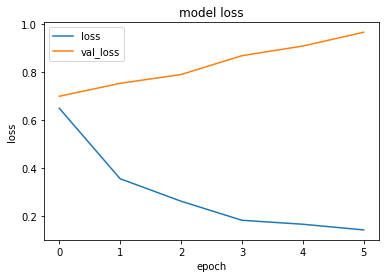

In [54]:
# plot the training history
plt.plot(H_model_2.history['loss'])
plt.plot(H_model_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

### Modelo 3
Modelo basado en *EfficientNet B0*, preentrenado con los pesos de Imagenet, al que se le sustituye su capa de clasificación por: una capa de *GlobalAveragePolling2D*, una capa de *BatchNormalization*, una capa de *dropout* con probabilidad del 20%, y finalmente una capa *fully connected*.
A partir de los pesos del modelo 2, se descongelan todas las capas y se entrena la red en su totalidad 

In [58]:
head_model = tf.keras.applications.EfficientNetB0(
    input_shape=shape, include_top=False, weights='imagenet')
# Freeze all layers
head_model.trainable = False
inputs = tf.keras.layers.Input(shape=shape)
# añadimos capas
head_model = head_model(inputs, training=True)
# GlobalMaxPooling2D
head_model = tf.keras.layers.GlobalAveragePooling2D()(head_model)
head_model = tf.keras.layers.BatchNormalization()(head_model)
head_model = Dropout(0.2)(head_model)
outputs = Dense(num_classes, activation='softmax')(head_model)
model3 = tf.keras.Model(inputs, outputs)

# save model3
model3.save('data/models/model_3.h5')

# cargamos los pesos del modelo 2
model3.load_weights('data/models/model_2_weights.h5', skip_mismatch=False, by_name=True)
# descongelamos todas las capas
model3.trainable = True

# Compile
model3.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

h_model_3 = model3.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=callbacks
)


Epoch 1/10
44/44 [==============================] - 24s 363ms/step - loss: 0.6063 - accuracy: 0.7353 - val_loss: 0.6969 - val_accuracy: 0.5632 - lr: 2.5000e-05
Epoch 2/10
44/44 [==============================] - 14s 327ms/step - loss: 0.3632 - accuracy: 0.8506 - val_loss: 0.7213 - val_accuracy: 0.5920 - lr: 2.5000e-05
Epoch 3/10
44/44 [==============================] - ETA: 0s - loss: 0.2666 - accuracy: 0.8832
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
44/44 [==============================] - 14s 322ms/step - loss: 0.2666 - accuracy: 0.8832 - val_loss: 0.7611 - val_accuracy: 0.5805 - lr: 2.5000e-05
Epoch 4/10
44/44 [==============================] - 14s 324ms/step - loss: 0.2369 - accuracy: 0.9014 - val_loss: 0.7871 - val_accuracy: 0.5805 - lr: 1.2500e-05
Epoch 5/10
44/44 [==============================] - ETA: 0s - loss: 0.2120 - accuracy: 0.9173
Epoch 5: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
44/44 [=========================

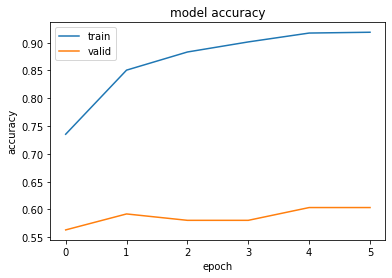

In [59]:
# plot the training history
plt.plot(h_model_3.history['accuracy'])
plt.plot(h_model_3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

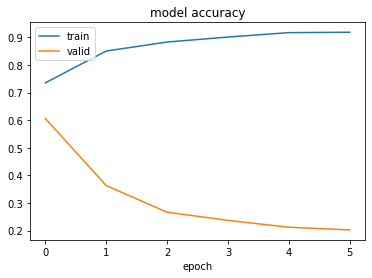

In [60]:
# plot accuracy and loss
plt.plot(h_model_3.history['accuracy'])
plt.plot(h_model_3.history['loss'])
plt.title('model accuracy')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

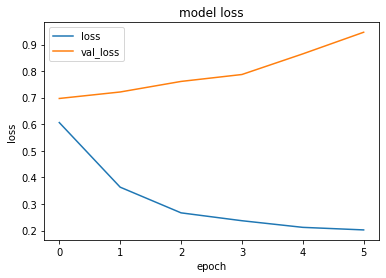

In [61]:
# plot the training history
plt.plot(h_model_3.history['loss'])
plt.plot(h_model_3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

### Modelo 4

Una capa convulucional

In [62]:
# CNN model of one convolutional layer
def build_model_4(num_classes, input_shape):
    # input
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    # convolutional layer
    x = tf.keras.layers.Conv2D(
        32, (3, 3), activation='relu', padding='same', name='conv1')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='pool1')(x)
    x = tf.keras.layers.Dropout(0.2, name='dropout1')(x)
    
    # flatten
    x = tf.keras.layers.Flatten()(x)
    
    # dense layer
    x = tf.keras.layers.Dense(128, activation='relu', name='dense1')(x)
    x = tf.keras.layers.Dropout(0.2, name='dropout2')(x)
    
    # output layer
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax', name='pred')(x)
    
    # compile
    model = tf.keras.Model(inputs, outputs, name="CNN")
    
    # get the model summary
    optimizer = tf.keras.optimizers.Adam()
    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=['accuracy']
    )

    # save the model
    model.save('data/models/model_4.h5')
    # save the weights
    model.save_weights('data/models/model_4_weights.h5')

    return model

model_4 = build_model_4(num_classes, shape)
# Fit
H_model_4 = model_4.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=callbacks
)


Epoch 1/10
44/44 [==============================] - 4s 74ms/step - loss: 19.3797 - accuracy: 0.7114 - val_loss: 0.9608 - val_accuracy: 0.6207 - lr: 0.0010
Epoch 2/10
44/44 [==============================] - 2s 56ms/step - loss: 1.2344 - accuracy: 0.7375 - val_loss: 0.6694 - val_accuracy: 0.4828 - lr: 0.0010
Epoch 3/10
44/44 [==============================] - 2s 55ms/step - loss: 0.5025 - accuracy: 0.7665 - val_loss: 0.6540 - val_accuracy: 0.5920 - lr: 0.0010
Epoch 4/10
44/44 [==============================] - 2s 56ms/step - loss: 0.4367 - accuracy: 0.8020 - val_loss: 0.6152 - val_accuracy: 0.7931 - lr: 0.0010
Epoch 5/10
44/44 [==============================] - 2s 56ms/step - loss: 0.4041 - accuracy: 0.8194 - val_loss: 0.5958 - val_accuracy: 0.7931 - lr: 0.0010
Epoch 6/10
44/44 [==============================] - 2s 56ms/step - loss: 0.3935 - accuracy: 0.8202 - val_loss: 0.5525 - val_accuracy: 0.8218 - lr: 0.0010
Epoch 7/10
44/44 [==============================] - 2s 55ms/step - loss: 0.

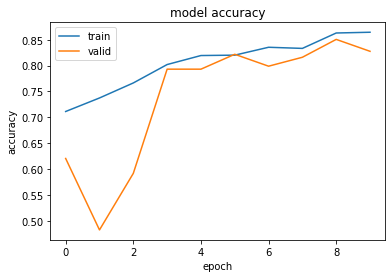

In [63]:
# plot the training history
plt.plot(H_model_4.history['accuracy'])
plt.plot(H_model_4.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

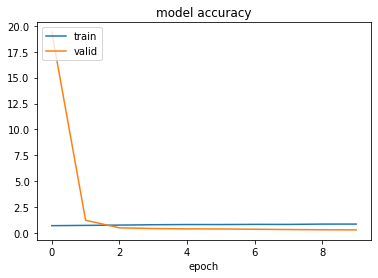

In [64]:
# plot accuracy and loss
plt.plot(H_model_4.history['accuracy'])
plt.plot(H_model_4.history['loss'])
plt.title('model accuracy')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

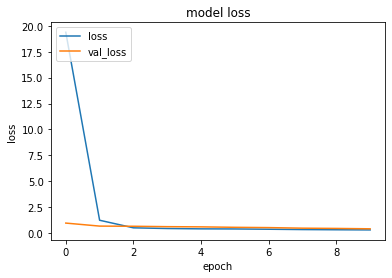

In [65]:
# plot the training history
plt.plot(H_model_4.history['loss'])
plt.plot(H_model_4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

### Modelo 5

Un modelo sencillo

In [66]:
# get a simply model
def build_model_5(num_classes, input_shape):
    # input
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    # flatten
    x = tf.keras.layers.Flatten()(inputs)
    
    # dense layer
    x = tf.keras.layers.Dense(128, activation='relu', name='dense1')(x)
    x = tf.keras.layers.Dropout(0.2, name='dropout2')(x)
    
    # output layer
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax', name='pred')(x)
    
    # compile
    model = tf.keras.Model(inputs, outputs, name="CNN")
    
    # get the model summary
    optimizer = tf.keras.optimizers.Adam()
    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=['accuracy']
    )
    # get the model summary
    model.summary()

    # save the model
    model.save('data/models/model_5_weights.h5')
    # save the weights
    model.save_weights('data/models/model_5_weights.h5')

    return model

model_5 = build_model_5(num_classes, shape)

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 dense1 (Dense)              (None, 128)               19267712  
                                                                 
 dropout2 (Dropout)          (None, 128)               0         
                                                                 
 pred (Dense)                (None, 2)                 258       
                                                                 
Total params: 19,267,970
Trainable params: 19,267,970
Non-trainable params: 0
_________________________________________________________________


In [67]:
# Fit
H_model_5 = model_5.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=callbacks
)

Epoch 1/10
44/44 [==============================] - 1s 24ms/step - loss: 9.7151 - accuracy: 0.5700 - val_loss: 0.6887 - val_accuracy: 0.5920 - lr: 0.0010
Epoch 2/10
44/44 [==============================] - 1s 17ms/step - loss: 0.6704 - accuracy: 0.5533 - val_loss: 0.6257 - val_accuracy: 0.6609 - lr: 0.0010
Epoch 3/10
44/44 [==============================] - 1s 17ms/step - loss: 0.6524 - accuracy: 0.6577 - val_loss: 0.6263 - val_accuracy: 0.6609 - lr: 0.0010
Epoch 4/10
44/44 [==============================] - 1s 17ms/step - loss: 0.6327 - accuracy: 0.6701 - val_loss: 0.5912 - val_accuracy: 0.7011 - lr: 0.0010
Epoch 5/10
44/44 [==============================] - 1s 17ms/step - loss: 0.6263 - accuracy: 0.6759 - val_loss: 0.5661 - val_accuracy: 0.7241 - lr: 0.0010
Epoch 6/10
44/44 [==============================] - 1s 17ms/step - loss: 0.6454 - accuracy: 0.6410 - val_loss: 0.5546 - val_accuracy: 0.7299 - lr: 0.0010
Epoch 7/10
44/44 [==============================] - 1s 16ms/step - loss: 0.6

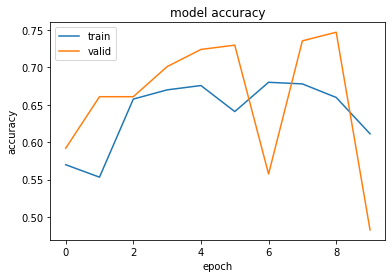

In [68]:
# plot the training history
plt.plot(H_model_5.history['accuracy'])
plt.plot(H_model_5.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

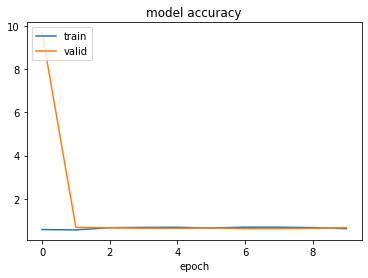

In [69]:
# plot accuracy and loss
plt.plot(H_model_5.history['accuracy'])
plt.plot(H_model_5.history['loss'])
plt.title('model accuracy')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

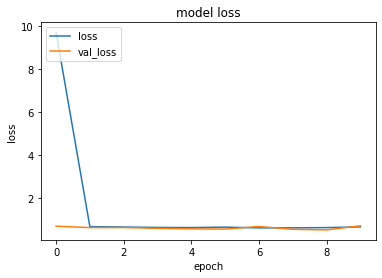

In [70]:
# plot the training history
plt.plot(H_model_5.history['loss'])
plt.plot(H_model_5.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

In [71]:
# get predictions
predictions = model_5.predict(x_test)

# get f1 score
f1_score(y_test, predictions)

# get accuracy
accuracy_score(y_test, predictions)
# get confusion matrix
confusion_matrix(y_test, predictions)


ValueError: ignored

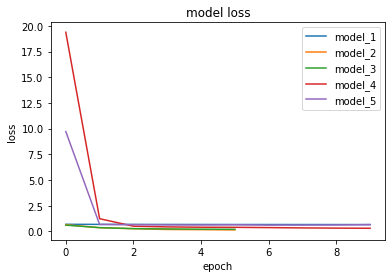

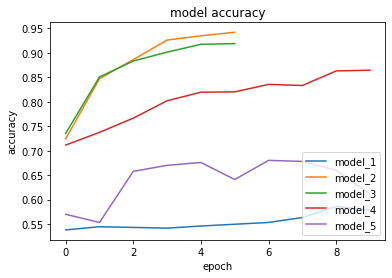

In [74]:
# plot the training history
plt.plot(history_1.history['loss'], label='model_1')
plt.plot(H_model_2.history['loss'], label='model_2')
plt.plot(h_model_3.history['loss'], label='model_3')
plt.plot(H_model_4.history['loss'], label='model_4')
plt.plot(H_model_5.history['loss'], label='model_5')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

# plot the training history
plt.plot(history_1.history['accuracy'], label='model_1')
plt.plot(H_model_2.history['accuracy'], label='model_2')
plt.plot(h_model_3.history['accuracy'], label='model_3')
plt.plot(H_model_4.history['accuracy'], label='model_4')
plt.plot(H_model_5.history['accuracy'], label='model_5')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.show()



# **Sección 3. Validación cruzada y discusión (3 puntos)**

El objetivo de la técnica de *cross validation* es seleccionar qué modelo es más adecuado, intentando reducir los sesgos y variaciones estadísticas en función de cómo se ha realizado la partición. En los apartados anteriores se ha trabajado con una de las particiones (**fold0**) y se han estudiado 5 modelos distintos.

En este caso, se debe:

- Aplicar una técnica de *cross validation* sobre el mejor de los modelos definidos anteriormente. Los datos ya contienen 10 particiones distintas (de **fold0** a **fold9**), por lo que se debe entrenar el modelo escogido sobre los datos de *train* de cada una de las particiones, evaluarlas, eligiendo en cada caso el mejor modelo de validación.
- Obtener el valor de **F1 score** de cada partición sobre el conjunto de test. De esta forma, se obtendrán 10 valores **F1 score** de test distintos.
- Calcular el valor medio y la desviación estándar.

Finalmente, fíjate en las matrices de *cross validation* que se han obtenido en la sección 2. El Glaucoma es una patología muy grave, por lo que es importante reducir los **falsos negativos (FN)** del modelo. ¿Qué estrategia seguirías para conseguir este propósito y qué penalizaciones podría tener esta decisión?



In [75]:
df_train.head()

,fold,set,status,image,full_path
0,Fold7,abnormal,abnormal,mnvrTcVYWX.jpg,data/practica_DL_UOC_2022/Fold7/train/abnormal...
1,Fold7,abnormal,abnormal,oIHpjYxUEv.jpg,data/practica_DL_UOC_2022/Fold7/train/abnormal...
2,Fold7,abnormal,abnormal,gwnLFsoNDm.jpg,data/practica_DL_UOC_2022/Fold7/train/abnormal...
3,Fold7,abnormal,abnormal,LccQdirYGU.jpg,data/practica_DL_UOC_2022/Fold7/train/abnormal...
4,Fold7,abnormal,abnormal,JbICuyWPsA.jpg,data/practica_DL_UOC_2022/Fold7/train/abnormal...


In [76]:
df_train = df_all[df_all['set']=='train']
df_test = df_all[df_all['set']=='test']
df_valid = df_all[df_all['set']=='valid']

y_train = pd.get_dummies(df_train['status'])
y_test = pd.get_dummies(df_test['status'])
y_valid = pd.get_dummies(df_valid['status'])


In [77]:
# import cross_val_score
from sklearn.model_selection import cross_val_score

In [79]:
# load model_1
model_1 = tf.keras.models.load_model('data/models/model_1.h5')
# cross validation. Each fold is a different set of data
scoring = 'accuracy'
scores = cross_val_score(model_1, X_train, y_train, cv=10, scoring=scoring)
print("Model 1: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


ValueError: ignored


# **Sección 4. Análisis crítico (1,5 puntos)**

Contesta, de forma razonada y justificada, a las siguientes preguntas:

  a) Para la realización de la práctica se han entregado las *folds* preparadas para el entrenamiento.

  i) Indicar qué estrategia de diseño hubieras seguido si las hubieras tenido que definir tú.

  ii) Indicar qué puntos son importantes en el diseño de estas particiones para que los modelos resultantes tengan una buena capacidad de generalización.

  b) Realizar un análisis crítico de los resultados obtenidos y las conclusiones a las que has llegado después de realizar esta práctica.


8. Entrega

El entregable será un archivo comprimido en formato ZIP con los siguientes documentos:

- **Informe en formato PDF** de entre 8 y 10 páginas de longitud, aproximadamente. No debe contener código (salvo mencionar alguna librería que sea importante indicar, o similar)
- **Código fuente** completo de la práctica. El código usado para todas las etapas de la práctica debe estar correctamente comentado para facilitar su comprensión. Podéis utilizar archivos Python nativos (.py) o basados en Jupyter Notebook (en este caso se debe entregar la versión .ipynb, y la exportación en formato HTML).

Para el **informe** se puede usar la siguiente guía:

- Tamaño de letra 11 o 12
- Fuente: Arial o similar
- Interlineado sencillo
- Las capturas de pantalla (por ejemplo, las gráficas de rendimiento) o los fragmentos de código (si se consideran relevantes) deben estar pensados para ilustrar y no para ser protagonistas.
- Se valora el informe como conjunto y no una sucesión de resultados.
